In [1]:
# required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# load the data
data = pd.read_csv("insurance.csv")
df = data.copy()

In [3]:
# pandas setups
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
# explore the data
def check_df(df):
    print("### HEAD ###")
    print(df.head())
    print("### TAIL ###")
    print(df.tail())
    print("### DESCRIBE ###") 
    print(df.describe().T)
    print("### INFO ###")
    print(df.info())

In [5]:
check_df(df)

### HEAD ###
   age     sex    bmi  children smoker     region   charges
0   19  female 27.900         0    yes  southwest 16884.924
1   18    male 33.770         1     no  southeast  1725.552
2   28    male 33.000         3     no  southeast  4449.462
3   33    male 22.705         0     no  northwest 21984.471
4   32    male 28.880         0     no  northwest  3866.855
### TAIL ###
      age     sex    bmi  children smoker     region   charges
1333   50    male 30.970         3     no  northwest 10600.548
1334   18  female 31.920         0     no  northeast  2205.981
1335   18  female 36.850         0     no  southeast  1629.833
1336   21  female 25.800         0     no  southwest  2007.945
1337   61  female 29.070         0    yes  northwest 29141.360
### DESCRIBE ###
            count      mean       std      min      25%      50%       75%  \
age      1338.000    39.207    14.050   18.000   27.000   39.000    51.000   
bmi      1338.000    30.663     6.098   15.960   26.296   30.40

## Data analysis

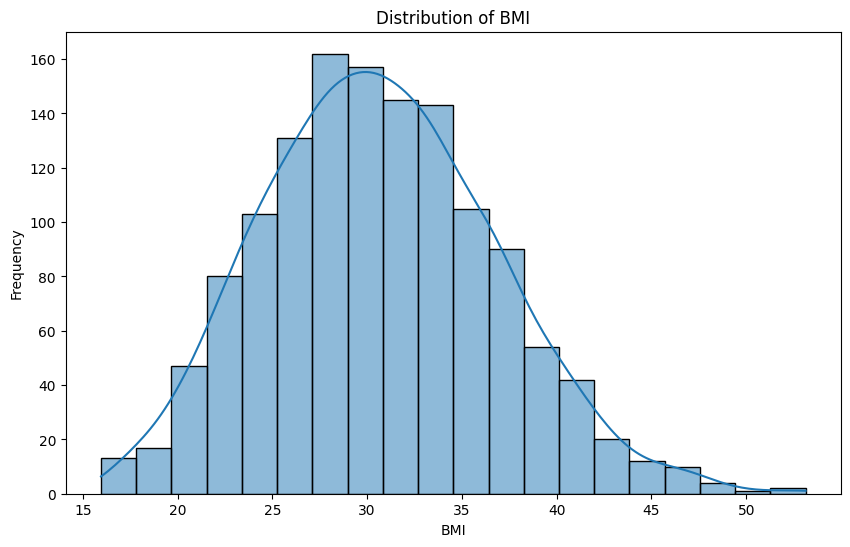

In [6]:
# distribution of Bmi 
df["bmi"].describe().T
plt.figure(figsize=(10, 6))
sns.histplot(data['bmi'], bins=20, kde=True)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

In [7]:
# group columns belong to their types
def grab_col_names(df, cat_th=10, car_th=20):
    cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
    num_but_cat = [col for col in df.columns if df[col].nunique() < cat_th and df[col].dtypes != "O"]
    cat_but_car = [col for col in df.columns if df[col].nunique() > car_th and df[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    
    # num_cols
    num_cols = [col for col in df.columns if df[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    print(f"Observations: {df.shape[0]}")
    print(f"Variables: {df.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

In [8]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 1338
Variables: 7
cat_cols: 4
num_cols: 3
cat_but_car: 0
num_but_cat: 1


In [9]:
# visualization the categorical cols
def cat_summary(df, col_name, plot=False):
    print(pd.DataFrame({col_name: df[col_name].value_counts(),
                       "Ratio" : 100 * df[col_name].value_counts() / len(df)}))
    print("####")
    if plot:
        sns.countplot(x=df[col_name], data=df)
        plt.show()

        sex  Ratio
male    676 50.523
female  662 49.477
####


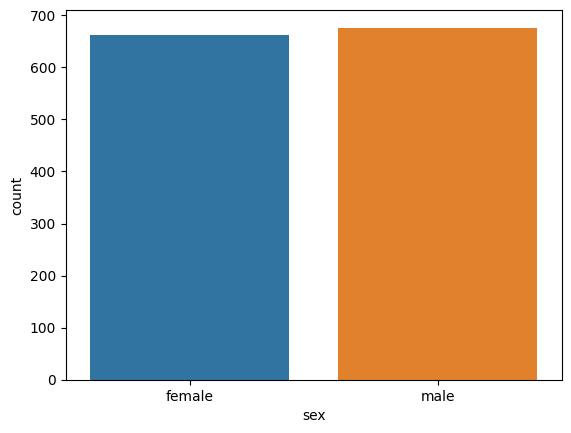

     smoker  Ratio
no     1064 79.522
yes     274 20.478
####


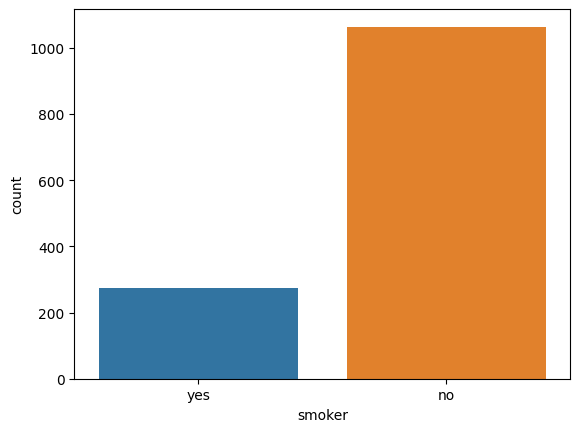

           region  Ratio
southeast     364 27.205
southwest     325 24.290
northwest     325 24.290
northeast     324 24.215
####


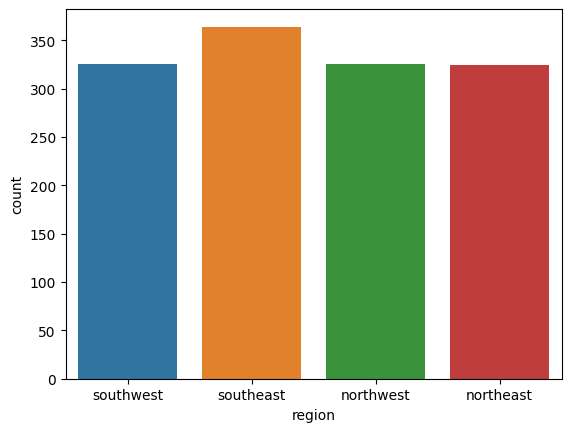

   children  Ratio
0       574 42.900
1       324 24.215
2       240 17.937
3       157 11.734
4        25  1.868
5        18  1.345
####


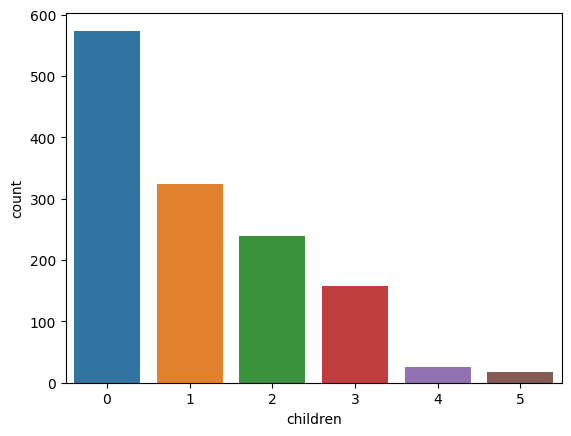

In [10]:
for col in cat_cols:
    cat_summary(df,col, plot=True)

In [11]:
num_cols = [col for col in num_cols if col not in "charges"]
num_cols

['age', 'bmi']

In [12]:
# numerical cols visualization
def num_summary(df, num_cols, plot=False):
    quantiles = [0.05, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99]
    print(df[num_cols].describe(quantiles).T)
    
    if plot:
        df[num_cols].hist(bins=20)
        plt.xlabel(num_cols)
        plt.title(num_cols)
        plt.show()

count   1338.000
mean      39.207
std       14.050
min       18.000
5%        18.000
20%       24.000
40%       34.000
50%       39.000
60%       44.000
80%       54.000
90%       59.000
95%       62.000
99%       64.000
max       64.000
Name: age, dtype: float64


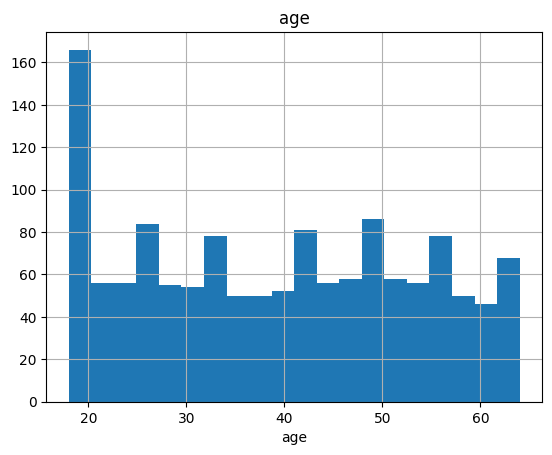

count   1338.000
mean      30.663
std        6.098
min       15.960
5%        21.256
20%       25.326
40%       28.797
50%       30.400
60%       32.032
80%       35.860
90%       38.619
95%       41.106
99%       46.408
max       53.130
Name: bmi, dtype: float64


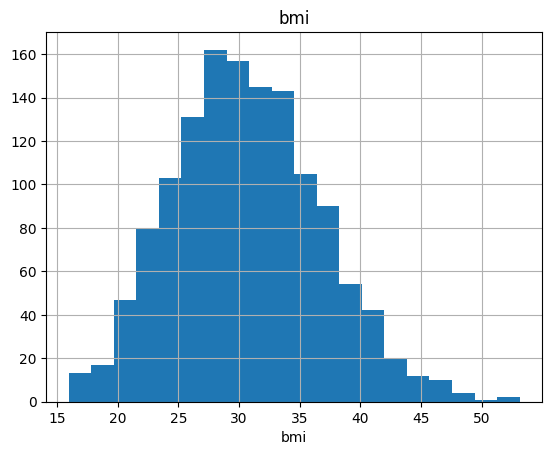

In [13]:
for col in num_cols:
    num_summary(df,col, plot=True)

In [14]:
# Examine the relationship between cols
def relationship_plot(df, col1, col2):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x=col1, y=col2)
    plt.title(f"{col1} vs {col2}")
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.show()

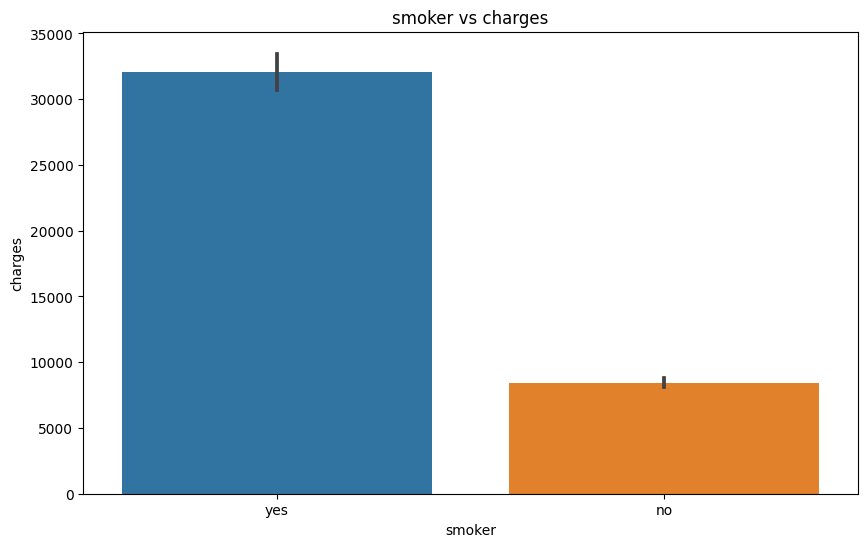

In [15]:
relationship_plot(df, "smoker", "charges") # smokers charges are higher

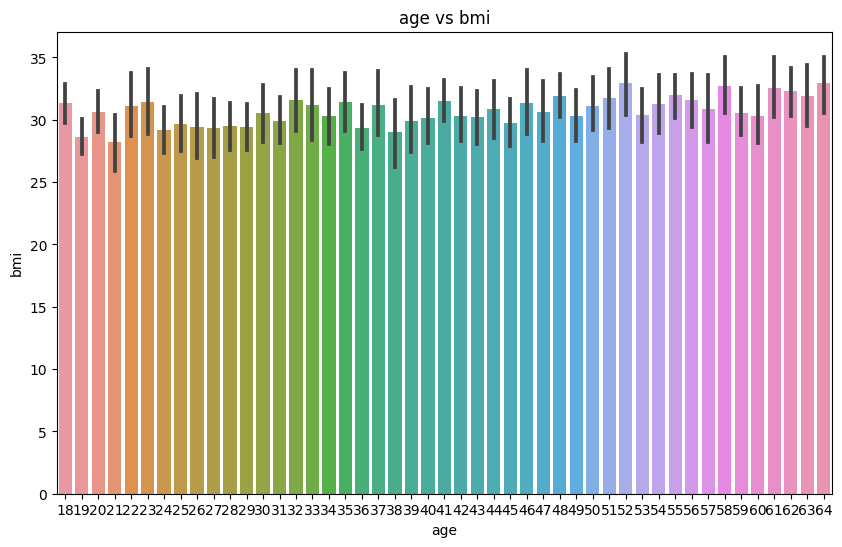

In [16]:
relationship_plot(df, "age", "bmi") # balanced distribution

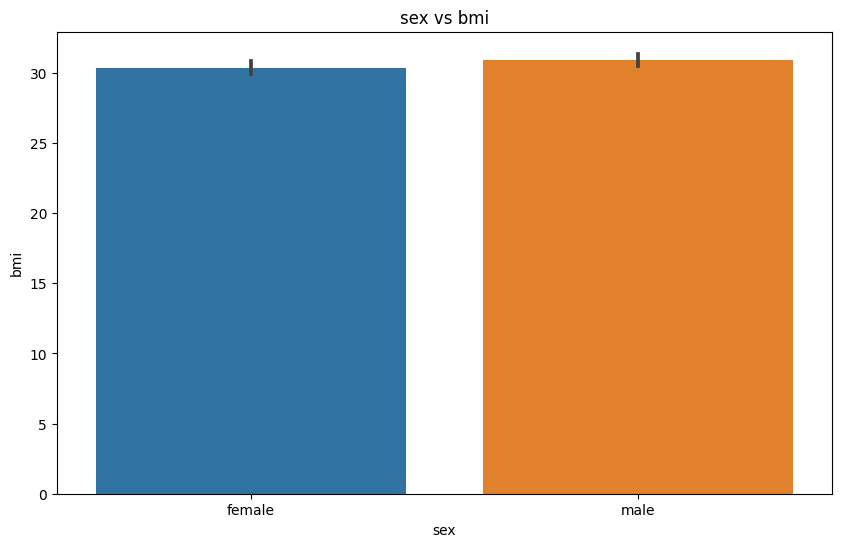

In [17]:
relationship_plot(df, "sex", "bmi") # balanced distribution

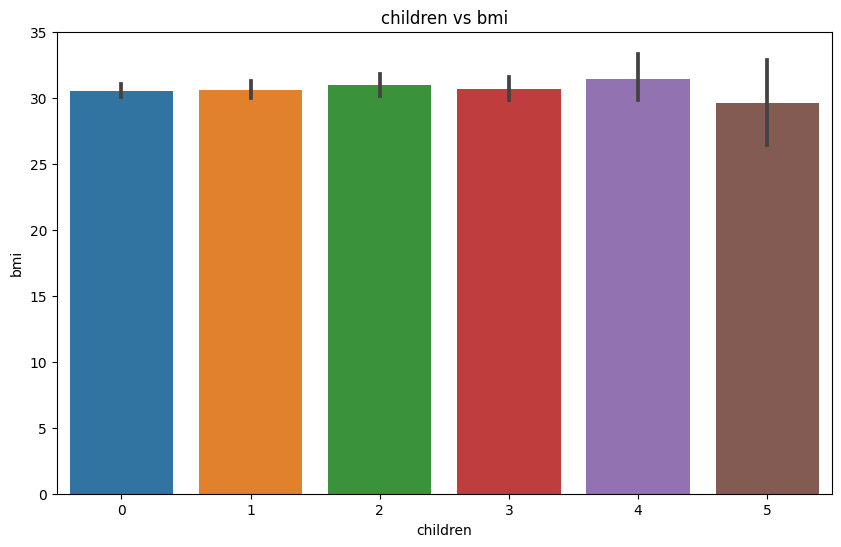

In [18]:
relationship_plot(df, "children", "bmi")

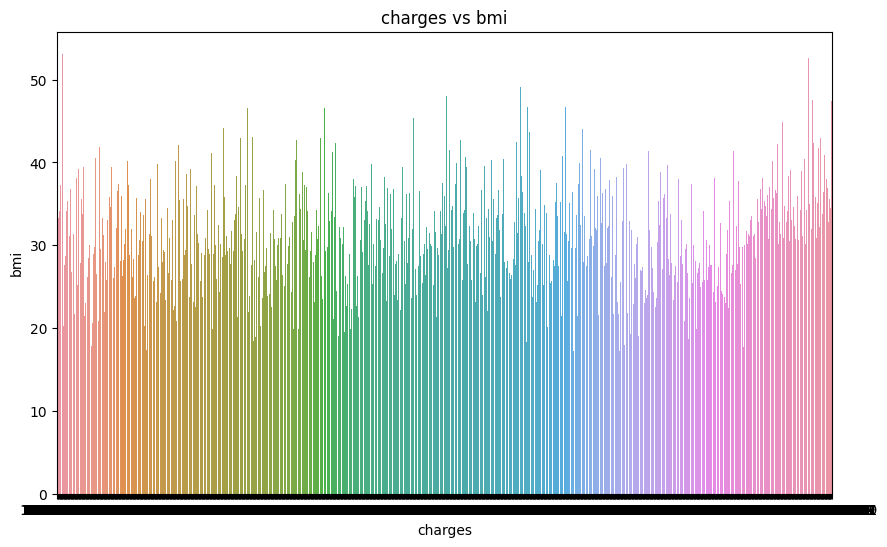

In [19]:
relationship_plot(df, "charges", "bmi")

In [20]:
df.groupby(["region","smoker"]).agg({"smoker":"count"}) # for each region non-smokers number is higher than smokers

smoker
region    smoker        
northeast no         257
          yes         67
northwest no         267
          yes         58
southeast no         273
          yes         91
southwest no         267
          yes         58

In [21]:
df.groupby("region").agg({"children" : "count"}).sort_values(by="children", ascending=False) 
# top-first region has the most children

,children
region,
southeast,364
northwest,325
southwest,325
northeast,324


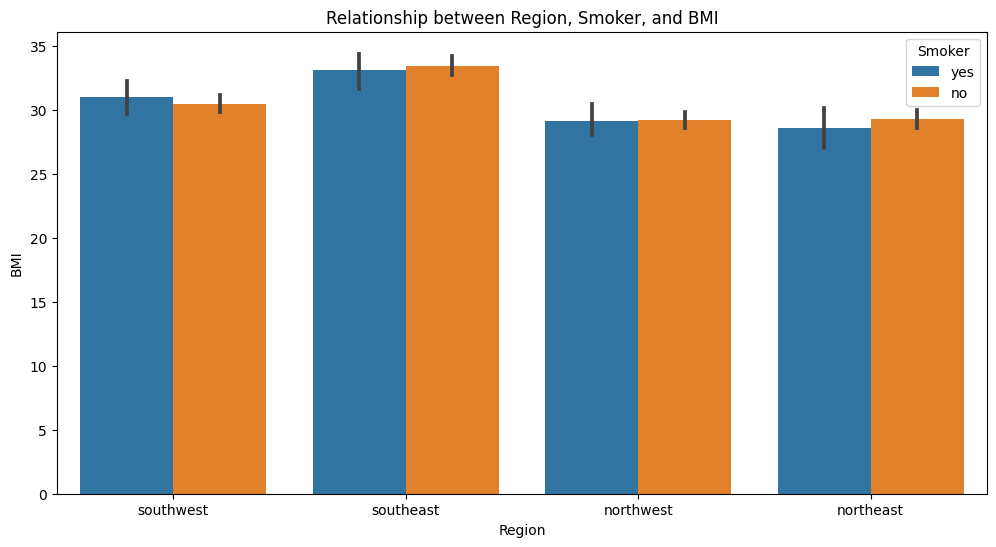

In [22]:
# relationship between “region”, “smoker” and “bmi”
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="region", y="bmi", hue="smoker")
plt.title("Relationship between Region, Smoker, and BMI")
plt.xlabel("Region")
plt.ylabel("BMI")
plt.legend(title="Smoker")
plt.show()

In [23]:
df.corr() # there is a possitive correlation between age and charges. But the correlation is not extremely strong.

/tmp/ipykernel_16822/180571291.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr() # there is a possitive correlation between age and charges. But the correlation is not extremely strong.


,age,bmi,children,charges
age,1.000,0.109,0.042,0.299
bmi,0.109,1.000,0.013,0.198
children,0.042,0.013,1.000,0.068
charges,0.299,0.198,0.068,1.000


/tmp/ipykernel_16822/3980663190.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), cmap="RdBu", annot=True)


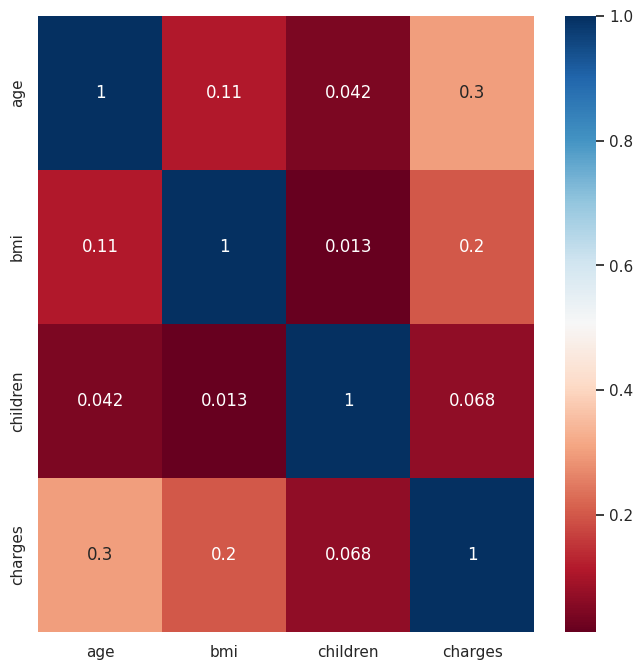

In [24]:
# visualize the corralation matrix
sns.set(rc={'figure.figsize': (8,8)})
sns.heatmap(df.corr(), cmap="RdBu", annot=True)
plt.show()

In [25]:
# outlier handiling

In [26]:
# calculates upper and lower limits for giving quantiles 
def outlier_thresholds(df, col_name, q1=0.05, q3=0.95):
    quantile1 = df[col_name].quantile(q1)
    quantile3 = df[col_name].quantile(q3)    
    iqr = quantile3 - quantile1
    up_limit = quantile3 + 1.5 * iqr
    low_limit = quantile1 -1.5 * iqr
    return low_limit, up_limit

In [27]:
# checks columns if there are any outliers or not
def chech_outlier(df, col_name):
    low_limit, up_limit = outlier_thresholds(df, col_name)
    if df[(df[col_name] > up_limit) | (df[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [28]:
# replaces the outliers to thresholds
def replace_with_thresholds(df, var, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(df, var, q1=0.05, q3=0.95)
    df.loc[(df[var] < low_limit), var] = low_limit
    df.loc[(df[var] > up_limit), var] = up_limit

In [29]:
for col in num_cols:
    print(col, chech_outlier(df, col))
    if chech_outlier(df,col):
        replace_with_thresholds(df, col)

age False
bmi False


## Data Preprocessing

In [30]:
# label encoding for binary columns
def label_encoder(df, binary_col):
    le = LabelEncoder()
    df[binary_col] = le.fit_transform(df[binary_col])
    return df

In [31]:
binary_cols = [col for col in df.columns if (df[col].nunique() == 2) and (df[col].dtype == "O")]

In [32]:
binary_cols

['sex', 'smoker']

In [33]:
for col in binary_cols:
    label_encoder(df, col)

In [34]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.924
1,18,1,33.770,1,0,southeast,1725.552
2,28,1,33.000,3,0,southeast,4449.462
3,33,1,22.705,0,0,northwest,21984.471
4,32,1,28.880,0,0,northwest,3866.855


In [35]:
# one-hot encoder function for categorical variables
def oh_encoder(df, cat_cols, drop_first=True):
    df = pd.get_dummies(df, columns=cat_cols, drop_first=drop_first)
    return df

In [36]:
df = oh_encoder(df, cat_cols)

In [37]:
df.head()

,age,bmi,charges,sex_1,smoker_1,region_northwest,region_southeast,region_southwest,children_1,children_2,children_3,children_4,children_5
0,19,27.900,16884.924,0,1,0,0,1,0,0,0,0,0
1,18,33.770,1725.552,1,0,0,1,0,1,0,0,0,0
2,28,33.000,4449.462,1,0,0,1,0,0,0,1,0,0
3,33,22.705,21984.471,1,0,1,0,0,0,0,0,0,0
4,32,28.880,3866.855,1,0,1,0,0,0,0,0,0,0


## Model Selection

In [38]:
y = df["charges"]
X = df.drop("charges", axis=1)

In [39]:
# scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [41]:
models = [("LR", LinearRegression()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("CatBoost", CatBoostRegressor(verbose=False))]

In [42]:
for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X_train, y_train, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE : {round(rmse, 4)} ({name})")

RMSE : 6157.0796 (LR)
RMSE : 6239.5874 (KNN)
RMSE : 6554.493 (CART)
RMSE : 5016.0737 (RF)
RMSE : 12570.3341 (SVR)
RMSE : 4742.2447 (GBM)
RMSE : 4981.3181 (CatBoost)


According to rmse values, hyper-parameters optimization made for RandomForestRegressor and GradientBoostingRegressor.

## Hyper-Parameter Optimization

In [43]:
# RandomForestRegressor instance
forest_model = RandomForestRegressor()

# hyper-parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search
grid_search = GridSearchCV(forest_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_forest_model = grid_search.best_estimator_

In [44]:
# GradientBoostingRegressor instance
gbm_model = GradientBoostingRegressor()

# hyper-parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search
grid_search = GridSearchCV(gbm_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_gbm_model = grid_search.best_estimator_

## Model evaluation

In [45]:
# predictions for random forest
y_pred = best_forest_model.predict(X_test)

# evaluation metrics calculation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"R-squared (R2): {r2:.3f}")

Mean Squared Error (MSE): 19737377.298
Root Mean Squared Error (RMSE): 4442.677
Mean Absolute Error (MAE): 2497.984
R-squared (R2): 0.873


In [46]:
# predictions for gbm
y_pred = best_gbm_model.predict(X_test)

# evaluation metrics calculation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"R-squared (R2): {r2:.3f}")

Mean Squared Error (MSE): 19890616.266
Root Mean Squared Error (RMSE): 4459.890
Mean Absolute Error (MAE): 2644.316
R-squared (R2): 0.872
